In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Shooting method

Consider the equation
\begin{align}
\frac{dy}{dx} = f(x, y, k),
\end{align}
where, $p$ is an unknown parameter. We are also given values of $y(x_1)$ and $y(x_2)$. This problem cannot be directly solved as an initial value problem, as we do not know $y^{\prime}(x_1)$ or $y^{\prime}(x_2)$. For specific values of $p$, the solution $y(x)$ satisfies the boundary condition. 

The shooting method involves the following steps:
- shoot from $y(x_1)$ with a guessed $p$ and integrate upto $x_2$
- compare the end point values $y(x_2)$ (between the computed and the given)
- minimize the difference by changing $p$  

The shooting method is commonly applied to boundary value problems, e.g. oscillating strings, Schroedinger equation, etc.

Let us apply the shooting method to find the normal modes of a vibrating string of length $L$ which is fixed at both ends. So the boundary conditions are $y(0) = y(L) = 0$. The corresponding equation is:
\begin{align}
\frac{\partial^2y}{\partial^2t} = v^2 \frac{\partial^2y}{\partial^2x}
\end{align}

For oscillating solutions, one can use a trial solution $y(x,t)=f(x)\cos(\omega t)$. The equation reduces to:
\begin{align}
\frac{d^2f}{dx^2} = -\frac{\omega^2}{v^2} f(x) = -k^2 f(x)
\end{align}

We choose $L =1$ and $v = 1$, and we need to find $y(x)$ for various $\omega$ values (or $k$ values).

We reduce the second-order differential equation to the first-order form:
\begin{align}
\frac{df}{dx} &= p \\
\frac{dp}{dx} &= -k^2 f
\end{align}

Using a vector $y$ to store $f$ and $p$, we get, 
\begin{align}
\frac{dy[0]}{dx} &= y[1] \\
\frac{dy[1]}{dx} &= -k^2 y[0]
\end{align}
or
\begin{align}
\frac{d}{dt}\begin{pmatrix}y[0] \\ y[1]\end{pmatrix} = \begin{pmatrix}y[1] \\ -k^2 y[0]\end{pmatrix}
\end{align}

In [2]:
# The following is standard RK4. It calls a function f(x,y,k) where k is a paramter
def rk4(f,x,y,k,h):
    k1 = h*f(x,y,k)
    k2 = h*f(x + h/2, y + k1/2, k)
    k3 = h*f(x + h/2, y + k2/2, k)
    k4 = h*f(x + h, y + k3, k)
    return y + (k1+2*k2+2*k3+k4)/6

# The following is a caller function. It integrates f from xlim[0] to xlim[1] with initial condition yini. 
# The parameter k is included in the argument along with the number of points N.
def caller_rk4(f,xlim,yini,k,N):
    x1, x2 = xlim
    xs = np.linspace(x1, x2, N)
    h = xs[1] - xs[0]
    y = yini
    ys = np.zeros((N,len(yini)))
    for i in range(N):
        ys[i] = np.array(y)
        y = rk4(f, xs[i], y, k, h)
    return xs, ys

# The following function calculates the departure from the boundary condition at the other end.
def score(k,f,ybound):
    xs, ys = caller_rk4(f,xlim,yini,k,N)
    return ys[-1][0] - ybound[1]
    
# This is an implementation of the secant method used for finding the root of the function score. 
def secant(ks,f,method,ybound):
    k1, k2 = ks
    iter = 0
    while abs(method(k2,f,ybound))>tol and iter<maxiter:
        f1 = method(k1,f,ybound)
        f2 = method(k2,f,ybound)
        k1, k2 = k2, (f2*k1 - f1*k2)/(f2 - f1)
        iter += 1
        print(iter, k1, k2, method(k2,f,ybound))
    if iter == maxiter:
        return iter, None
    else:
        return iter, k2

# The following is an implementation of Simpson's 1/3 method (for normalization)
def simp13(y,h):
    store = y[0]**2 + y[-1]**2
    for i in range(2,len(y)):
        if i%2==0:
            store += 4*y[i]**2
        else:
            store += 2*y[i]**2
    return store*(h/3)


In [3]:
# define the ODE function
def odefun1(x,y,k):
    return np.array([y[1], -k**2 * y[0]]) # here k is wavenumber in the unit of pi

# Initialization
xlim = (0.0, 1.0)
yini = (0.0, 0.2) # 0.2 is an arbitrary number finally adjusted by normalization

# Boundary condition
ybound = (0.0, 0.0)

# Number of points
N = 129

# Max iteration and tolerance for secant
maxiter = 50
tol = 1.0e-6

In [4]:
ks = np.linspace(0.01,10,500);
scores = [score(k,odefun1,ybound) for k in ks];

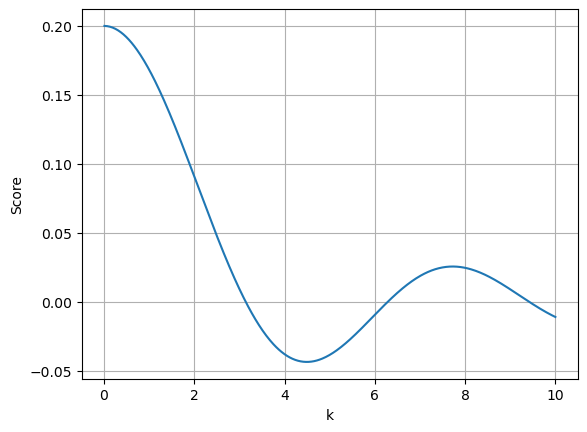

In [5]:
plt.plot(ks, scores);
plt.grid();
plt.xlabel("k");
plt.ylabel("Score");

In [6]:
kini=(2.,4.);
iter,keigen = secant(kini,odefun1,score,ybound);

1 4.0 3.4122829393547915 -0.01567259463827126
2 3.4122829393547915 2.9967629583181297 0.0096319875472843
3 2.9967629583181297 3.154927327666126 -0.0008452980250207285
4 3.154927327666126 3.142166767870761 -3.654196514650716e-05
5 3.142166767870761 3.141590208442737 1.5626768057005504e-07


In [7]:
xs, ys = caller_rk4(odefun1,xlim,yini,keigen,200);
h = xs[1]-xs[0]
y1 = [y[0] for y in ys];
normfact = simp13(y1,h);
y1 = y1/normfact;

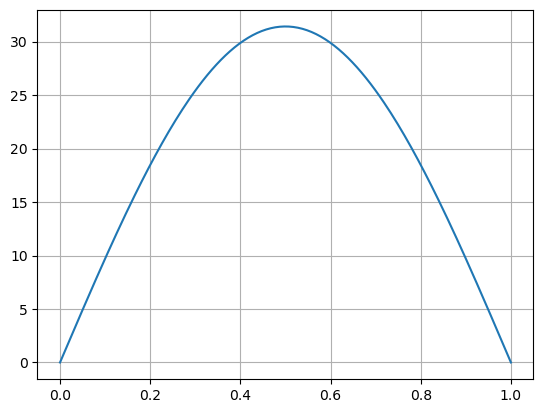

In [8]:
plt.plot(xs,y1); 
plt.grid()

## Schroedinger Equation: bound state solutions

Let us try to find the solutions of Schoedinger equation for a negative potential well. So we try to solve an equation of the form:
\begin{align}
\frac{d^2\psi}{dx^2} + k^2(x) \psi(x) = 0
\end{align}
where, 
\begin{align}
k^2(x) = \frac{2m}{\hbar^2}\left(E - V(x)\right).
\end{align}

For simplicity let us assume $\frac{2m}{\hbar^2} = 1$. 
Also let us choose $V(x)$ as,
\begin{align}
V(x) =
\begin{cases}
0 \qquad\qquad\qquad\qquad \text{for } \vert x\vert >L_{\circ} \\
-V_{\circ}(L_{\circ} - x)/2 \qquad \text{for } \vert x\vert \le L_{\circ}
\end{cases}
\end{align}
with $\psi(\pm 3L_{\circ}) = 0$

We must find the energies $E$ (eigenvalues) for which there is a 
nonzero solution to this problem. At one of these eigenvalues, we expect
the eigenfunction to oscillate in the classically allowed regions where
$E > V(x)$ and to behave exponentially in the classically forbidden 
regions where $E < V(x)$. Thus, there wiU be "bound" solutions with $E < 0$,
which are localized within the well and decay exponentially toward the
walls and "continuum" solutions with $E > 0$, which have roughly constant
magnitude throughout the entire region between the walls.

Upon integrating toward larger $x$ from $x_{\rm min}$,
we can generate a solution, $\psi_{<}$ which increases exponentially through
the classically forbidden region and then oscillates beyond the left 
turning point in the classically allowed region (see the lower portion of 
the figure below). 

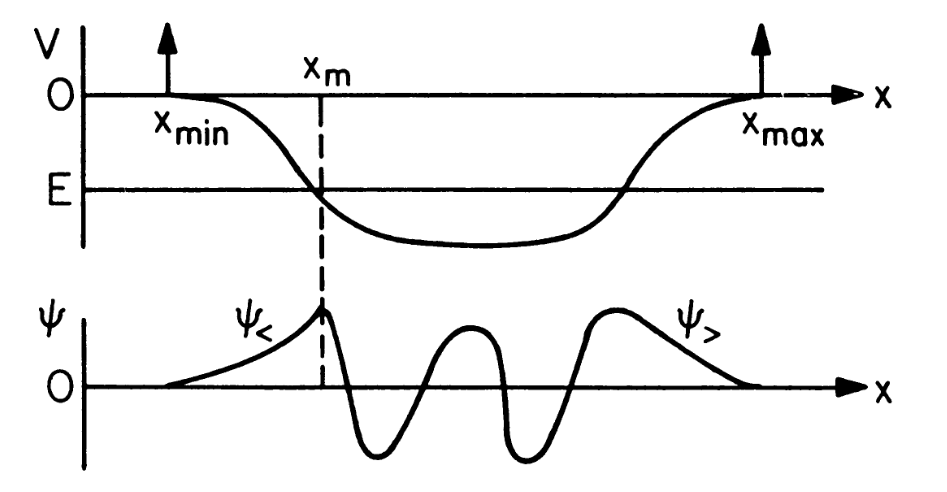

If we were to continue integrating past the right turning point, the integration would become numerically unstable since, even at an 
exact eigenvalue where $\psi_{<}(x_{\rm max}) = 0$, there can be an admixture of the
undesirable exponentially growing solution. As a general rule, integration
into a classically forbidden region is unlikely to be inaccurate. Therefore,
at each energy, it is wiser to generate a second solution, $\psi_{>}$, by 
integrating from $x_{\rm max}$ toward smaller $x$. To determine whether the energy is an
eigenvalue, $\psi_{<}$ and $\psi_{>}$ can be compared at a matching point, $x_{\rm m}$, chosen
so that neither integration will be inaccurate. (A convenient choice for
$x_{\rm m}$ is the left turning point.) Since both $\psi_{<}$ and $\psi_{>}$ satisfy a 
homogeneous equation, their normallzations can always be chosen so that the two
functions are equal at $x_{\rm m}$. An eigenvalue is then signalled by equality of
the derivatives at $x_{\rm m}$ i.e., the solutions match smoothly, as is invoked in
analytical solutions of such problems. Thus,
$$ \left.\frac{d\psi_{<}}{dx}\right\vert_{x_m} - \left.\frac{d\psi_{>}}{dx}\right\vert_{x_m} = 0.$$

In [9]:
# The rhs of Schoedinger equation (using vectorized form)
def odefun2(x,y,E):
    k2 = E - pot(x);
    return np.array([y[1], -k2 * y[0]]) 

# The potential
def pot(x):
    if abs(x)>Lo:
        return 0.0
    else:
        return -Vo*(Lo - x**3)/2

# The score. Note: we are integrating from the right and from the left and checking the difference at one of the turning points.
def score2(E,f,ybound):
    # Start from the left
    yini1 = (ybound[0], 1.0e-2);
    # psi_<
    xs1, ys1 = caller_rk4(odefun2,xlim,yini1,E,N)
    a = abs(xs1 + Lo);
    # find solution at x = Lo (left turning point)
    n1=np.where(a == np.min(a))[0][0]
    # Start from right
    yini2 = (ybound[1], 1.0e-2)
    # psi_>
    xs2, ys2 = caller_rk4(odefun2,xlim[-1::-1],yini2,E,N)
    a = abs(xs2 + Lo);
    # find solution at x = Lo (left turning point)
    n2=np.where(a == np.min(a))[0][0]
    # scale psi_>
    ys2 = ys1[n1][0]*ys2/ys2[n2][0]
    # return the difference of derivatives as score
    return ys1[n1][1] - ys2[n2][1]

In [10]:
Vo = 40.0
Lo = 1.0
xlim = (-3.0, 3.0)
ybound = (0.0, 0.0)
yini = (ybound[0], 0.1) # 1.0e-2 is an arbitrary number finally adjusted by normalization
N = 129
maxiter = 50
tol = 1.0e-5

In [11]:
Es = np.linspace(-Vo, 0, 1000);
scores = [score2(E, odefun2, ybound) for E in Es];

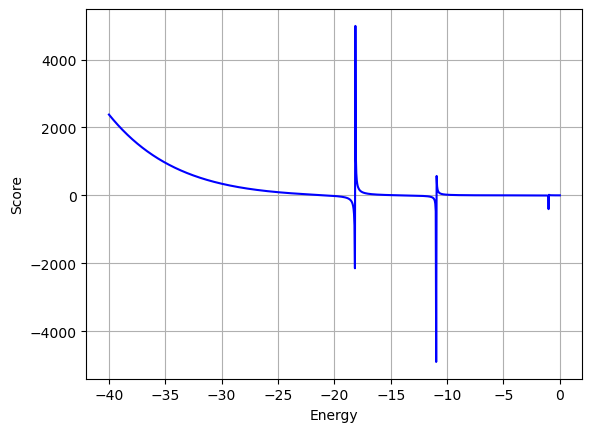

In [12]:
plt.plot(Es,scores,'b-');
plt.grid()
plt.xlabel("Energy");
plt.ylabel("Score");

(-21.0, -20.0)

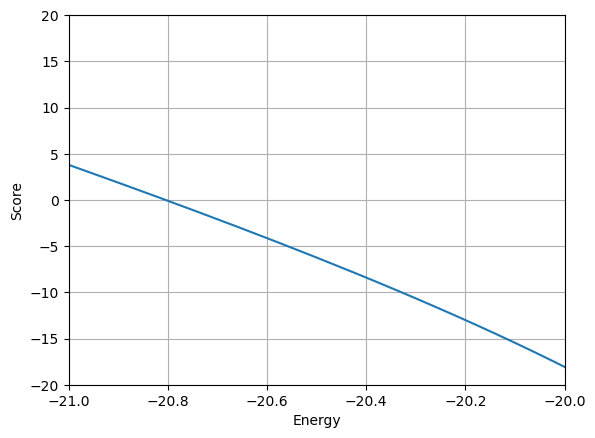

In [17]:
plt.plot(Es,scores);
plt.grid()
plt.xlabel("Energy");
plt.ylabel("Score");
plt.ylim([-20.,20.])
plt.xlim([-21.0,-20.0])

In [18]:
Eini=(-21.0,-20.0)
iter,Eeigen = secant(Eini,odefun2,score2,ybound);

1 -20.0 -20.826273570932155 0.42667055749647886
2 -20.826273570932155 -20.80721719844809 0.05074973545755057
3 -20.80721719844809 -20.804644566644665 -0.00010242513605618342
4 -20.804644566644665 -20.804649748374597 2.4860980829544133e-08


Text(0, 0.5, '$\\psi$')

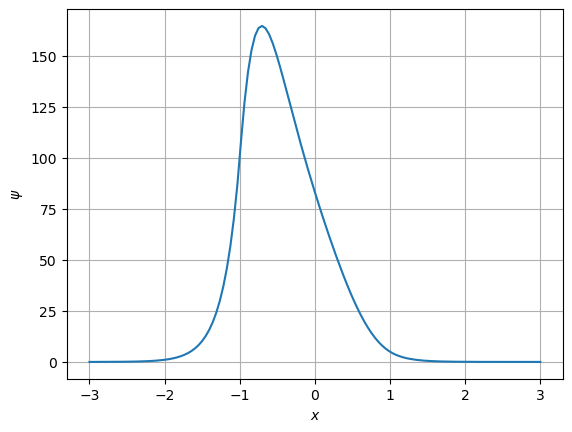

In [19]:
xs, ys = caller_rk4(odefun2, xlim, yini, Eeigen, N);
y1 = [y[0] for y in ys];
plt.plot(xs, y1);
plt.grid();
plt.xlabel("$x$")
plt.ylabel("$\\psi$")

(-14.0, -13.0)

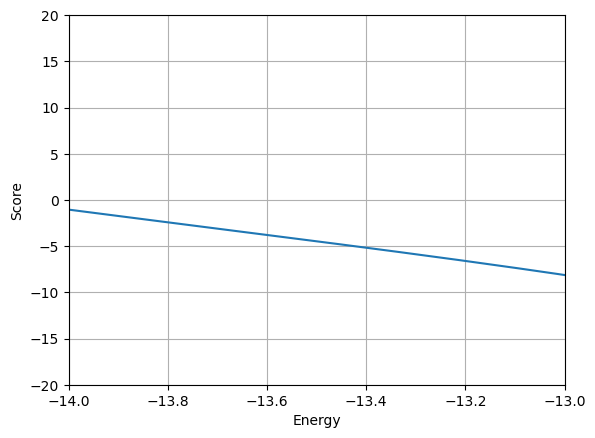

In [20]:
plt.plot(Es,scores);
plt.grid()
plt.xlabel("Energy");
plt.ylabel("Score");
plt.ylim([-20.,20.])
plt.xlim([-15.0,-13.0])

In [21]:
Eini=(-15.0,-13.0)
iter,Eeigen = secant(Eini,odefun2,score2,ybound);

1 -13.0 -14.092403018462745 -0.4069355703312869
2 -14.092403018462745 -14.149981992713517 -0.001323341584834381
3 -14.149981992713517 -14.15016984861538 6.323037219146954e-06


Text(0, 0.5, '$\\psi$')

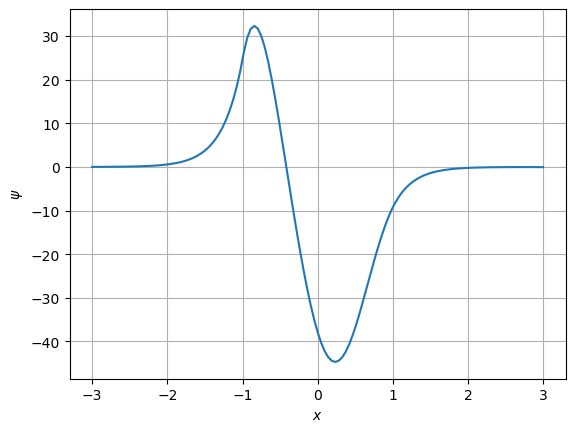

In [22]:
xs, ys = caller_rk4(odefun2, xlim, yini, Eeigen, N);
y1 = [y[0] for y in ys];
plt.plot(xs, y1);
plt.grid();
plt.xlabel("$x$")
plt.ylabel("$\\psi$")

(-5.0, -0.0)

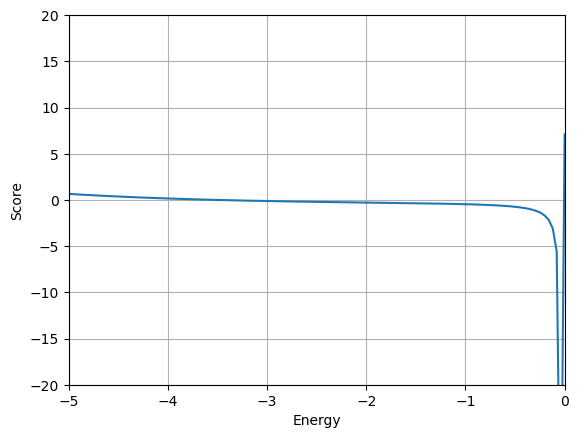

In [25]:
plt.plot(Es,scores);
plt.grid()
plt.xlabel("Energy");
plt.ylabel("Score");
plt.ylim([-20.,20.])
plt.xlim([-5.0,-0.0])

1 -2.0 -3.2962955919844 -0.05469307334859427
2 -3.2962955919844 -3.6013494310549214 0.02619802617960809
3 -3.6013494310549214 -3.5025523012251654 -0.00156106022980676
4 -3.5025523012251654 -3.508108257495541 -4.151400067978206e-05
5 -3.508108257495541 -3.508260046212438 6.805463054204708e-08


Text(0, 0.5, '$\\psi$')

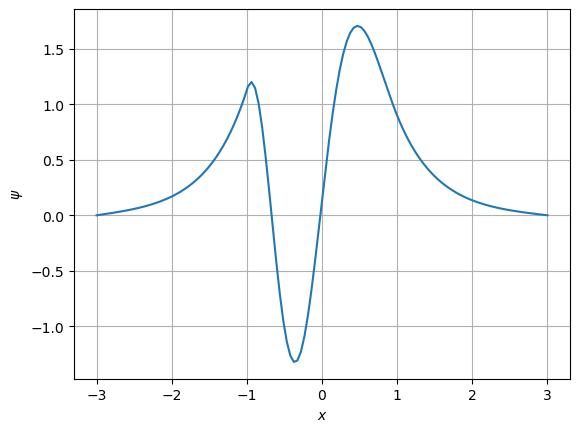

In [26]:
Eini=(-4.0,-2.0)
iter,Eeigen = secant(Eini,odefun2,score2,ybound);
xs, ys = caller_rk4(odefun2, xlim, yini, Eeigen, N);
y1 = [y[0] for y in ys];
plt.plot(xs, y1);
plt.grid();
plt.xlabel("$x$")
plt.ylabel("$\\psi$")

(-25.0, -5.0)

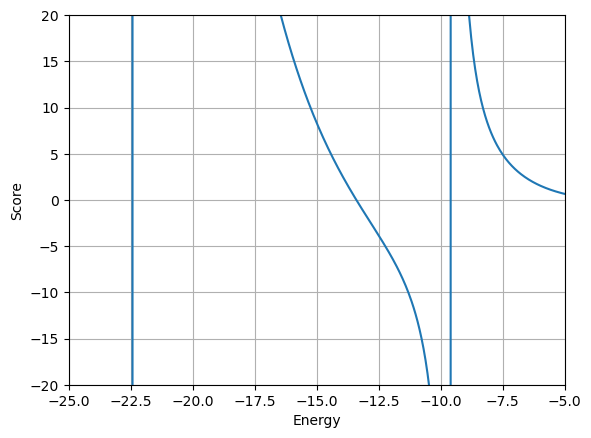

In [27]:
plt.plot(Es,scores);
plt.grid()
plt.xlabel("Energy");
plt.ylabel("Score");
plt.ylim([-20.,20.])
plt.xlim([-25.0,-5.0])

1 -10.0 -14.159358157262282 3.578444558039597
2 -14.159358157262282 -13.827829856532636 1.9523900285568914
3 -13.827829856532636 -13.429766607857399 0.13364428947623086
4 -13.429766607857399 -13.400516296011888 0.004513921610491245
5 -13.400516296011888 -13.399493812943534 9.364345467055557e-06


Text(0, 0.5, '$\\psi$')

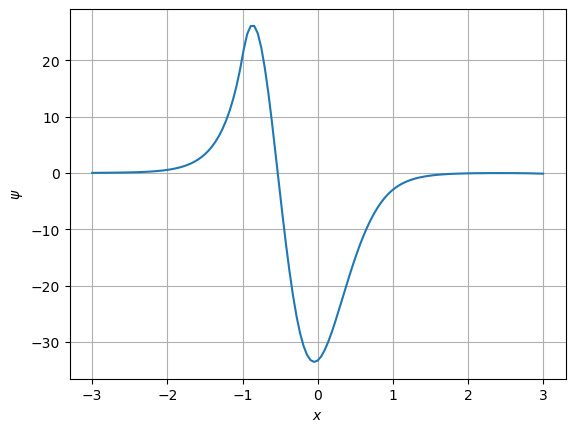

In [28]:
Eini=(-15.0,-10.0)
iter,Eeigen = secant(Eini,odefun2,score2,ybound);
xs, ys = caller_rk4(odefun2, xlim, yini, Eeigen, N);
y1 = [y[0] for y in ys];
plt.plot(xs, y1);
plt.grid();
plt.xlabel("$x$")
plt.ylabel("$\\psi$")

In [23]:
Es1 = np.linspace( 0,10, 1000);
scores1 = [score2(E, odef1, ybound) for E in Es1];

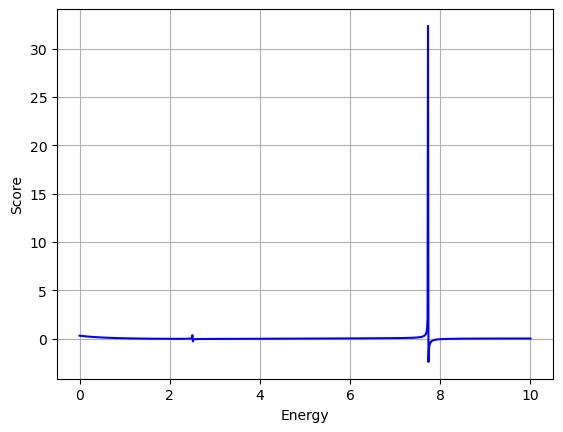

In [24]:
plt.plot(Es1,scores1,'b-');
plt.grid()
plt.xlabel("Energy");
plt.ylabel("Score");